Epoch 1/100
3/3 [==============================] - 2s 145ms/step - loss: 0.3412 - mean_absolute_error: 0.5356 - val_loss: 0.3177 - val_mean_absolute_error: 0.5158
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.3116 - mean_absolute_error: 0.5107 - val_loss: 0.3002 - val_mean_absolute_error: 0.5008
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2957 - mean_absolute_error: 0.4970 - val_loss: 0.2873 - val_mean_absolute_error: 0.4887
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2833 - mean_absolute_error: 0.4845 - val_loss: 0.2733 - val_mean_absolute_error: 0.4747
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2687 - mean_absolute_error: 0.4699 - val_loss: 0.2581 - val_mean_absolute_error: 0.4595
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2530 - mean_absolute_error: 0.4545 - val_loss: 0.2420 - val_mean_absolute_error: 0.4431
Epoch 7/100
3/3 [==========

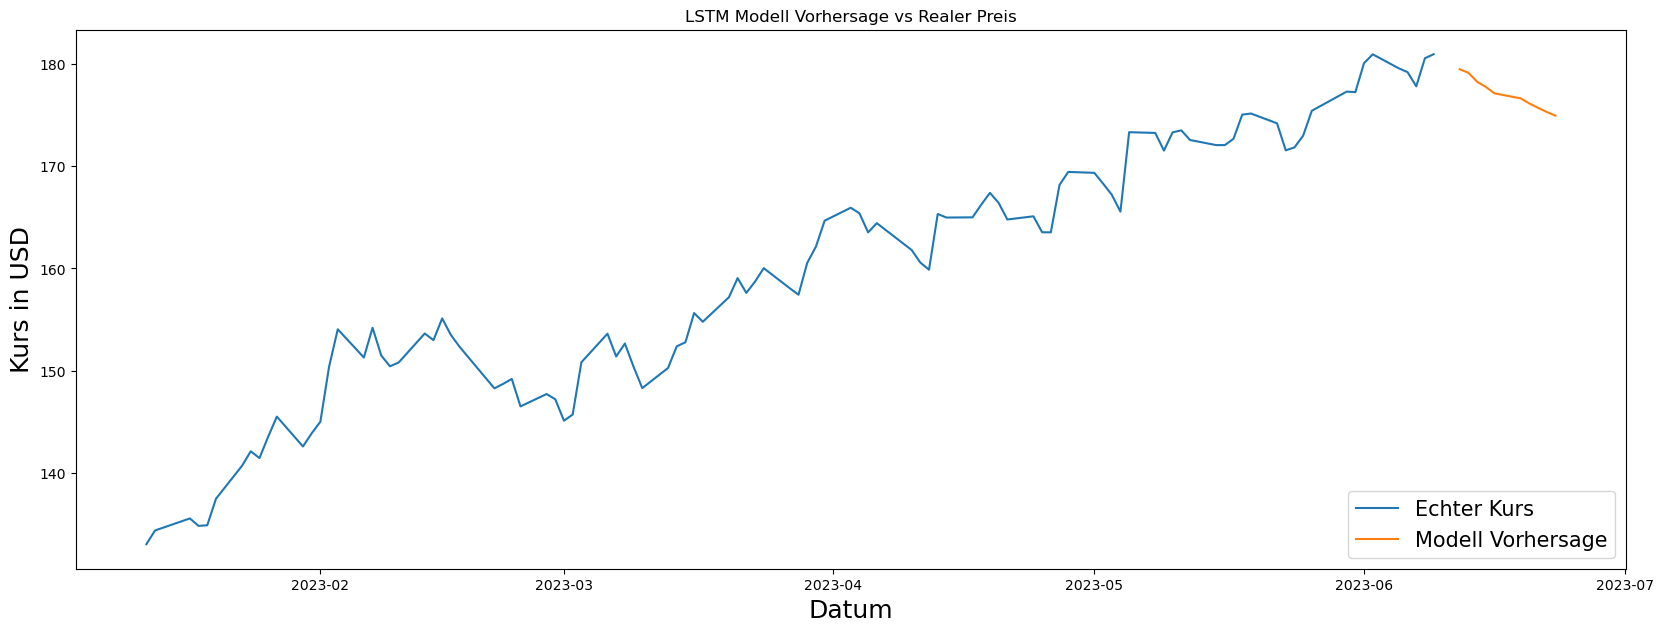

                           Predicted Close
2023-06-12 00:00:00-04:00       179.489883
2023-06-13 00:00:00-04:00       179.144699
2023-06-14 00:00:00-04:00       178.264465
2023-06-15 00:00:00-04:00       177.762314
2023-06-16 00:00:00-04:00       177.129318
2023-06-19 00:00:00-04:00       176.642502
2023-06-20 00:00:00-04:00       176.144608
2023-06-21 00:00:00-04:00       175.717209
2023-06-22 00:00:00-04:00       175.310928
2023-06-23 00:00:00-04:00       174.948410


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

def create_model():
    model = Sequential([
        layers.Input((2, 1)),
        layers.LSTM(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=200):
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)

def lstm_stock_prediction(ticker_symbol, start_date, end_date):
    ticker = yf.Ticker(ticker_symbol)
    df = ticker.history(start=start_date, end=end_date, actions=False)
    df = df[['Close']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    train_len = int(len(scaled_data) * 0.9)
    train_data = scaled_data[:train_len, :]
    test_data = scaled_data[train_len - 2:, :]

    x_train, y_train = [], []
    interval = 2

    for i in range(interval, len(train_data)):
        x_train.append(train_data[i - interval:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = create_model()
    train_model(model, x_train, y_train, x_train, y_train, epochs=100)

    x_test = np.array([test_data[-interval:, 0]])
    predictions = []

    for _ in range(10):
        prediction = model.predict(x_test)
        predictions.append(prediction[0][0])
        x_test = np.append(x_test[:, 1:], prediction, axis=1)

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    last_date = df.index[-1]
    prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10, freq='B')

    prediction_table = pd.DataFrame(predictions, columns=['Predicted Close'], index=prediction_dates)

    # Plot
    plt.figure(figsize=(20, 7))
    plt.title("LSTM Modell Vorhersage vs Realer Preis")
    plt.xlabel("Datum", fontsize=18)
    plt.ylabel("Kurs in USD", fontsize=18)
    plt.plot(df['Close'])
    plt.plot(prediction_dates, predictions)
    plt.legend(['Echter Kurs', 'Modell Vorhersage'], loc='lower right', fontsize=15)
    plt.show()

    return prediction_table

# Beispielaufruf der Funktion
prediction_table = lstm_stock_prediction('AAPL', '2023-01-12', '2023-06-12')
print(prediction_table)


Epoch 1/100
3/3 [==============================] - 2s 142ms/step - loss: 0.3377 - mean_absolute_error: 0.5316 - val_loss: 0.3021 - val_mean_absolute_error: 0.5025
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2936 - mean_absolute_error: 0.4949 - val_loss: 0.2771 - val_mean_absolute_error: 0.4795
Epoch 3/100
3/3 [==============================] - 0s 15ms/step - loss: 0.2694 - mean_absolute_error: 0.4721 - val_loss: 0.2535 - val_mean_absolute_error: 0.4565
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2462 - mean_absolute_error: 0.4495 - val_loss: 0.2305 - val_mean_absolute_error: 0.4337
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2230 - mean_absolute_error: 0.4261 - val_loss: 0.2085 - val_mean_absolute_error: 0.4105
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2004 - mean_absolute_error: 0.4022 - val_loss: 0.1846 - val_mean_absolute_error: 0.3838
Epoch 7/100
3/3 [==========

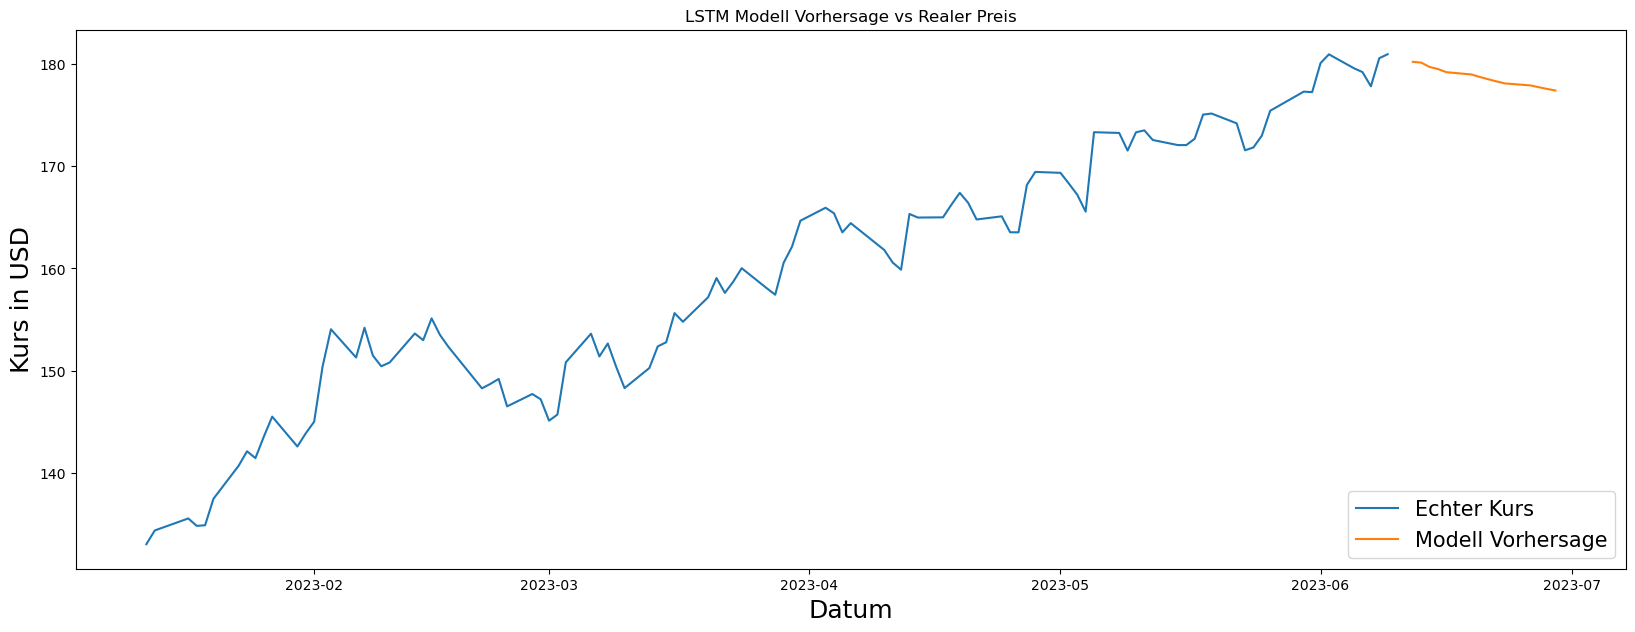

                           Predicted Close
2023-06-12 00:00:00-04:00       180.216110
2023-06-13 00:00:00-04:00       180.140854
2023-06-14 00:00:00-04:00       179.713272
2023-06-15 00:00:00-04:00       179.509598
2023-06-16 00:00:00-04:00       179.203110
2023-06-19 00:00:00-04:00       178.977295
2023-06-20 00:00:00-04:00       178.727554
2023-06-21 00:00:00-04:00       178.511902
2023-06-22 00:00:00-04:00       178.296661
2023-06-23 00:00:00-04:00       178.099854
2023-06-26 00:00:00-04:00       177.910431
2023-06-27 00:00:00-04:00       177.733719
2023-06-28 00:00:00-04:00       177.565872
2023-06-29 00:00:00-04:00       177.408234
